# Algoritmos de optimización - Seminario<br>
Nombre y Apellidos: Marc Llinares Ronda   <br>
Url: https://github.com/marcllinares14/Algoritmos<br>
Problema:
> 1. Sesiones de doblaje <br>
>2. Organizar los horarios de partidos de La Liga<br>
>3. Combinar cifras y operaciones

Descripción del problema:

### PROBLEMA 2
Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la audiencia.<br>

Los horarios disponibles se conocen a priori y son los siguientes: <br>


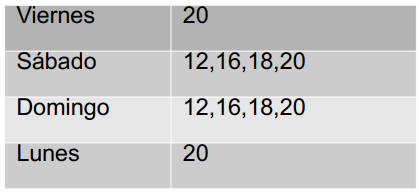

<br>

En primer lugar se clasifican los equipos en tres categorías según el numero de
seguidores( que tiene relación directa con la audiencia). Hay 3 equipos en la
categoría A, 11 equipos de categoría B y 6 equipos de categoría C. <br>

Se conoce estadísticamente la audiencia que genera cada partido según los equipos que se enfrentan y en horario de sábado a las 20h (el mejor en todos los casos) <br>

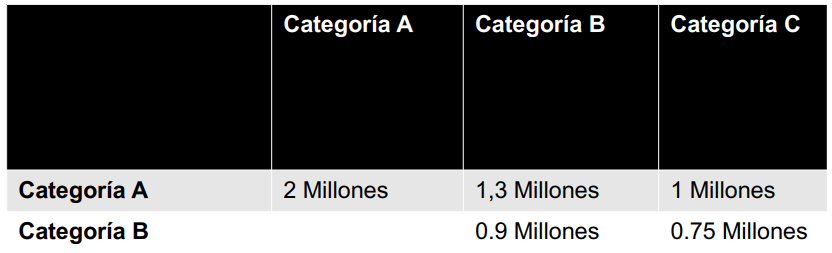

<br>

Si el horario del partido no se realiza a las 20 horas del sábado se sabe que se reduce según los coeficientes de la siguiente tabla. Debemos asignar obligatoriamente siempre un partido el viernes y un partido el lunes. <br>

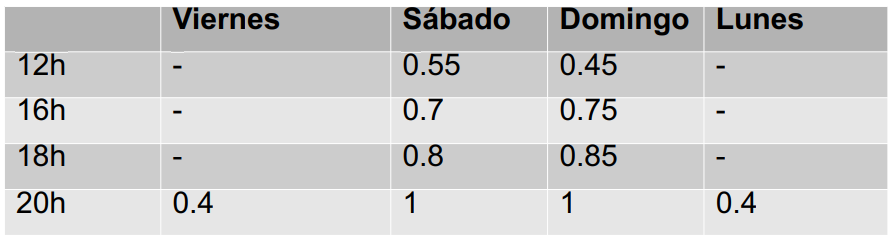

<br>

Es posible la coincidencia de horarios pero en este
caso la audiencia de cada partido se verá afectada y
se estima que se reduce en porcentaje según la
siguiente tabla dependiendo del número de
coincidencias: <br>

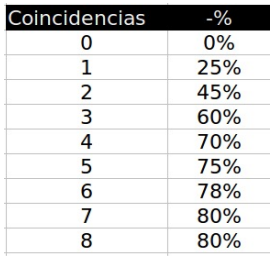

<br><br><br>


(*) La respuesta es obligatoria





                                        

### IMPORTS

In [1]:
import random
from itertools import combinations

#### DATABASE

In [2]:
# Horarios [(DIA, HORA)]
franjas = [
    ("Viernes", 20),
    ("Sábado", 12),
    ("Sábado", 16),
    ("Sábado", 18),
    ("Sábado", 20),
    ("Domingo", 12),
    ("Domingo", 16),
    ("Domingo", 18),
    ("Domingo", 20),
    ("Lunes", 20)
]

# Correcciones de audiencia por horarios [-]
correct_horarios = {
    ("Viernes", 20): 0.40,
    ("Sábado", 12): 0.55,
    ("Sábado", 16): 0.70,
    ("Sábado", 18): 0.80,
    ("Sábado", 20): 1.00,
    ("Domingo", 12): 0.45,
    ("Domingo", 16): 0.75,
    ("Domingo", 18): 0.85,
    ("Domingo", 20): 1.00,
    ("Lunes", 20): 0.40
}

# Correcciones por coincidencias en horarios [-]
correct_coincidencias = {
    0: 0.00,
    1: 0.25,
    2: 0.45,
    3: 0.60,
    4: 0.70,
    5: 0.75,
    6: 0.78,
    7: 0.80,
    8: 0.80,
    9: 0.80,
    10: 0.80
}

# Audiencia baseline [millones]
baseline = {
    ("A", "A"): 2.00,
    ("A", "B"): 1.30,
    ("A", "C"): 1.00,
    ("B", "B"): 0.90,
    ("B", "C"): 0.75,
    ("C", "C"): 0.75
}

# Categorías de equipos
equipos = {
    "FCB": "A",
    "Real Madrid": "A",
    "R. Sociedad": "A",
    "Valencia": "B",
    "ATM": "B",
    "Athletic Bilbao": "B",
    "Sevilla": "B",
    "Betis": "B",
    "Celta": "B",
    "Villarreal": "B",
    "Espanyol": "B",
    "Getafe": "B",
    "Alaves": "B",
    "Levante": "B",
    "Mallorca": "C",
    "Eibar": "C",
    "Leganes": "C",
    "Osasuna": "C",
    "Granada": "C",
    "Valladolid": "C"
}

### FUNCTIONS

In [3]:
def get_categorias(partido, equipos):
    return tuple(sorted((equipos[partido[0]], equipos[partido[1]])))

def random_solutions():
  while True:
    asignacion = list(range(10))
    random.shuffle(asignacion)
    if 0 in asignacion and 9 in asignacion:
            return asignacion

def calcular_audiencia(combinacion, partidos, franjas, baseline, correct_horarios, correct_coincidencias):
  total_audiencia = 0

  # Contar cuántos partidos hay en cada franja
  contador_franjas = {}
  for i, horario_id in enumerate(combinacion):
      franja = franjas[horario_id]
      if franja in contador_franjas:
          contador_franjas[franja] += 1
      else:
          contador_franjas[franja] = 1

  for partido_idx, horario_id in enumerate(combinacion):
      franja = franjas[horario_id]
      cat1 = partidos[partido_idx]["cat1"]
      cat2 = partidos[partido_idx]["cat2"]

      clave_baseline = (cat1, cat2) if (cat1, cat2) in baseline else (cat2, cat1)
      audiencia_base = baseline[clave_baseline] # audiencia baseline

      # Corrección por horario
      correccion_horario = correct_horarios.get(franja, 1.0)

      # Corrección por coincidencias
      n_coinciden = contador_franjas[franja] - 1
      correccion_coincidencia = correct_coincidencias.get(n_coinciden, 0.0)

      # Audiencia final
      audiencia_final = audiencia_base * correccion_horario * (1 - correccion_coincidencia)
      total_audiencia += audiencia_final

  return total_audiencia

def cruce_order(padre1, padre2): # Técnica de Order Crossover (combinar dos combinaciones para crear una resultado de ambas)
  start, end = sorted(random.sample(range(len(padre1)), 2)) # índices de inicio y final

  hijo = [None] * len(padre1) # inicialización

  hijo[start:end + 1] = padre1[start:end + 1] # lo que se toma del primer padre

  posicion = (end + 1) % len(padre1)
  for elem in padre2: # rellenar el hijo con el resto del segundo padre
      if elem not in hijo:
          hijo[posicion] = elem
          posicion = (posicion + 1) % len(padre1)

  return hijo

def mutar(combinacion, prob_mutacion=0.1):
    nueva = combinacion.copy()
    if random.random() < prob_mutacion:
        i, j = random.sample(range(len(nueva)), 2)
        nueva[i], nueva[j] = nueva[j], nueva[i]
    return nueva

def algoritmo_genetico(partidos, franjas, baseline, correct_horarios, correct_coincidencias,
                       poblacion, umbral, numero_hijos, max_iters, tolerancia):

    # Inicialización
    combinaciones = [random_solutions() for _ in range(poblacion)]
    audiencias = [
        calcular_audiencia(comb, partidos, franjas, baseline, correct_horarios, correct_coincidencias)
        for comb in combinaciones
    ]

    mejor_anterior = max(audiencias) # mejor del espacio de soluciones de la inicialización/step anterior

    # Iteraciones
    for iteracion in range(max_iters):

        umbral_audiencia = mejor_anterior * umbral # se toman las combinaciones cuya audiencia es un % de la mejor del anterior espacio de soluciones
        indices_mejores = [i for i, aud in enumerate(audiencias) if aud >= umbral_audiencia]
        mejores_combinaciones = [combinaciones[i] for i in indices_mejores] # lista de mejores combinaciones basadas en el umbral

        # Generación de hijos a partir de las mejores combinaciones del step anterior
        hijos = []
        for _ in range(numero_hijos):
            padre1, padre2 = random.sample(mejores_combinaciones, 2) # se toman dos padres randoms
            hijo = cruce_order(padre1, padre2) # se calcula una combinación de ambos
            hijos.append(hijo)

        combinaciones = mejores_combinaciones + hijos

        # Evaluación de las nuevas combinaciones
        audiencias = [
            calcular_audiencia(comb, partidos, franjas, baseline, correct_horarios, correct_coincidencias)
            for comb in combinaciones
        ]

        mejor_actual = max(audiencias)

        # Check de convergencia
        if abs(mejor_actual - mejor_anterior) < tolerancia:
            break # se para la optimización si el error entre el step anterior y el actual es menor a la tolerancia indicada por el usuario

        mejor_anterior = mejor_actual

    mejor_idx = audiencias.index(max(audiencias))
    return combinaciones[mejor_idx], max(audiencias)

def printear_horarios(combinacion, partidos, franjas, audiencia_total):
    print("Programación final:")

    # Cálculo del equipo correspondiente a cada franja horaria
    partidos_info = []
    for i, horario_id in enumerate(combinacion):
        dia, hora = franjas[horario_id]
        equipo1 = partidos[i]['cat1']
        equipo2 = partidos[i]['cat2']
        partidos_info.append((dia, hora, equipo1, equipo2))

    orden_dias = {
        "Viernes": 0,
        "Sábado": 1,
        "Domingo": 2,
        "Lunes": 3
    }

    partidos_info.sort(key=lambda x: (orden_dias[x[0]], x[1])) # ordenar por día y hora

    for dia, hora, equipo1, equipo2 in partidos_info:
        print(f"- {dia} {hora}h: {equipo1} vs {equipo2}")

    print(f"\nAudiencia total estimada: {audiencia_total:.2f} millones")


### SETTINGS

In [4]:
poblacion=100
umbral=0.98
numero_hijos=20
max_iters=50
tolerancia=1e-3

### INPUTS

In [5]:
partidos_input = [
    ("Celta", "Real Madrid"),
    ("Valencia", "R. Sociedad"),
    ("Mallorca", "Eibar"),
    ("Athletic Bilbao", "FCB"),
    ("Leganes", "Osasuna"),
    ("Villarreal", "Granada"),
    ("Alaves", "Levante"),
    ("Espanyol", "Sevilla"),
    ("Betis", "Valladolid"),
    ("ATM", "Getafe")
]

Conversión de equipos a categorias:

In [6]:
partidos = []
for idx, p in enumerate(partidos_input):
    cat1, cat2 = get_categorias(p, equipos)
    partidos.append({"id": idx, "cat1": cat1, "cat2": cat2})

In [7]:
display(partidos)

[{'id': 0, 'cat1': 'A', 'cat2': 'B'},
 {'id': 1, 'cat1': 'A', 'cat2': 'B'},
 {'id': 2, 'cat1': 'C', 'cat2': 'C'},
 {'id': 3, 'cat1': 'A', 'cat2': 'B'},
 {'id': 4, 'cat1': 'C', 'cat2': 'C'},
 {'id': 5, 'cat1': 'B', 'cat2': 'C'},
 {'id': 6, 'cat1': 'B', 'cat2': 'B'},
 {'id': 7, 'cat1': 'B', 'cat2': 'B'},
 {'id': 8, 'cat1': 'B', 'cat2': 'C'},
 {'id': 9, 'cat1': 'B', 'cat2': 'B'}]

### SOLUCIÓN

In [8]:
mejor_combinacion, audiencia_total = algoritmo_genetico(partidos, franjas, baseline, correct_horarios, correct_coincidencias, poblacion, umbral, numero_hijos, max_iters, tolerancia)

printear_horarios(mejor_combinacion, partidos, franjas, audiencia_total)


Programación final:
- Viernes 20h: C vs C
- Sábado 12h: C vs C
- Sábado 16h: B vs B
- Sábado 18h: B vs C
- Sábado 20h: A vs B
- Domingo 12h: B vs B
- Domingo 16h: B vs B
- Domingo 18h: A vs B
- Domingo 20h: A vs B
- Lunes 20h: B vs C

Audiencia total estimada: 7.03 millones


(*)¿Cuantas posibilidades hay sin tener en cuenta las restricciones?<br>



¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones.




Respuesta

Si no se tiene en cuenta las restricciones, al haber 10 partidos y 10 franjas horarias, y si cada partido puede ser asignado libremente a cualquier franja horaria, el número de posibilidades es una permutación de los partidos sobre las franjas: 10!

In [9]:
import math
print(f"Hay 10! = {math.factorial(10)} posibilidades")

Hay 10! = 3628800 posibilidades


Modelo para el espacio de soluciones<br>
(*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumentalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguentalo)


Respuesta

Pese a que para la "database" he utilizado estructuras como diccionarios o listas o tuplas anidadas, la estructura de datos principalmente utilizada en el algoritmo es aquella en la que se guardaba en cada iteración la asignación de cada partido a cada franja horaria: una lista. <br><br>
La razón de utilizar ésta es porque las listas son simples, indexadas y mutables. El uso de diccionarios y tuplas me ha venido bien para almacenar la información que implicaba varias variables en una misma "linea", como el día, la hora y el coeficiente de corrección de audiencia por horario. Sin embargo, pese a que podría haber utilizado un diccionario como estructura de datos principal, esto hubiese añadido complejidad y me hubiese obligado a desarrollar más el código de todas las operaciones que lo involucrasen.

Según el modelo para el espacio de soluciones<br>
(*)¿Cual es la función objetivo?

(*)¿Es un problema de maximización o minimización?

Respuesta

En mi algoritmo la función objetivo es 'calcular_audiencia()', en la cual se calcula, para una asignación de partidos a las franjas horarias dada, la audiencia total. Para cada partido, se calcula la audiencia baseline y a continuación se le aplican los coeficientes correctores según las limitaciones apicadas.

En este caso corresponde a un problema de maximización, dado que busco en cada iteración de 'algoritmos_geneticos()' el máximo de 'calcular_audiencia()'.

Diseña un algoritmo para resolver el problema por fuerza bruta

Respuesta

In [10]:
from itertools import permutations

def fuerza_bruta(partidos, franjas, baseline, correct_horarios, correct_coincidencias):
    mejores_franjas = None
    mejor_audiencia = 0

    # Todas las permutaciones posibles de franjas para los partidos
    for combinacion in permutations(range(len(franjas))):
        audiencia = calcular_audiencia(combinacion, partidos, franjas, baseline, correct_horarios, correct_coincidencias)

        if audiencia > mejor_audiencia:
            mejor_audiencia = audiencia
            mejores_franjas = combinacion

    return mejores_franjas, mejor_audiencia

mejor_combinacion, audiencia_total = algoritmo_genetico(partidos, franjas, baseline, correct_horarios, correct_coincidencias, poblacion, umbral, numero_hijos, max_iters, tolerancia)

printear_horarios(mejor_combinacion, partidos, franjas, audiencia_total)

Programación final:
- Viernes 20h: B vs B
- Sábado 12h: C vs C
- Sábado 16h: A vs B
- Sábado 18h: B vs C
- Sábado 20h: A vs B
- Domingo 12h: C vs C
- Domingo 16h: B vs B
- Domingo 18h: B vs B
- Domingo 20h: A vs B
- Lunes 20h: B vs C

Audiencia total estimada: 6.96 millones


Calcula la complejidad del algoritmo por fuerza bruta

Respuesta

Si hay n=10 partidos, que se quiere asignarlos a n franjas horarias. Todas las permutaciones de n franjas son n! combinaciones. Por tanto, para cada combinación, hay que calcular la audiencia con una función con coste lineal con n, dado que evalúa todos los partidos a la vez. Por tanto:<br>
Complejidad = O(n!·n)

(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta

Respuesta

El propio algoritmo genético que he desarrollado mejoraría la complejidad del de fuerza bruta, dado que utiliza técnicas que exploran las cominaciones más prometedoras en cada iteración, en lugar de evaluar todas las posibles. La complejidad ahora dependería linealmente del número de generaciones y del tamaño de la población, ambos seteados por el usuario, junto con el número de partidos. Por tanto, el incremento del número de partidos no tendría un impacto ni similar al que tendría con el algoritmo por fuerza bruta.

(*)Calcula la complejidad del algoritmo

Respuesta

Complejidad = O(G·P·n), siendo:<br>
 G = generaciones<br>
 P = población<br>
 n = número de partidos

Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios

Respuesta

In [13]:
equipos_gen = [
    "FCB", "Real Madrid", "R. Sociedad", "Valencia", "ATM",
    "Athletic Bilbao", "Sevilla", "Betis", "Celta", "Villarreal",
    "Espanyol", "Getafe", "Alaves", "Levante", "Mallorca",
    "Eibar", "Leganes", "Osasuna", "Granada", "Valladolid"
]
random.shuffle(equipos_gen)
partidos_input = [(equipos_gen[i], equipos_gen[i+1]) for i in range(0, len(equipos_gen), 2)]

Aplica el algoritmo al juego de datos generado

Respuesta

In [14]:
# Volver a definir la función del algoritmo
def algoritmo_genetico(partidos, franjas, baseline, correct_horarios, correct_coincidencias,
                       poblacion, umbral, numero_hijos, max_iters, tolerancia):

    # Inicialización
    combinaciones = [random_solutions() for _ in range(poblacion)]
    audiencias = [
        calcular_audiencia(comb, partidos, franjas, baseline, correct_horarios, correct_coincidencias)
        for comb in combinaciones
    ]

    mejor_anterior = max(audiencias) # mejor del espacio de soluciones de la inicialización/step anterior

    # Iteraciones
    for iteracion in range(max_iters):

        umbral_audiencia = mejor_anterior * umbral # se toman las combinaciones cuya audiencia es un % de la mejor del anterior espacio de soluciones
        indices_mejores = [i for i, aud in enumerate(audiencias) if aud >= umbral_audiencia]
        mejores_combinaciones = [combinaciones[i] for i in indices_mejores] # lista de mejores combinaciones basadas en el umbral

        # Generación de hijos a partir de las mejores combinaciones del step anterior
        hijos = []
        for _ in range(numero_hijos):
            padre1, padre2 = random.sample(mejores_combinaciones, 2) # se toman dos padres randoms
            hijo = cruce_order(padre1, padre2) # se calcula una combinación de ambos
            hijos.append(hijo)

        combinaciones = mejores_combinaciones + hijos

        # Evaluación de las nuevas combinaciones
        audiencias = [
            calcular_audiencia(comb, partidos, franjas, baseline, correct_horarios, correct_coincidencias)
            for comb in combinaciones
        ]

        mejor_actual = max(audiencias)

        # Check de convergencia
        if abs(mejor_actual - mejor_anterior) < tolerancia:
            break # se para la optimización si el error entre el step anterior y el actual es menor a la tolerancia indicada por el usuario

        mejor_anterior = mejor_actual

    mejor_idx = audiencias.index(max(audiencias))
    return combinaciones[mejor_idx], max(audiencias)

mejor_combinacion, audiencia_total = algoritmo_genetico(partidos, franjas, baseline, correct_horarios, correct_coincidencias, poblacion, umbral, numero_hijos, max_iters, tolerancia)

printear_horarios(mejor_combinacion, partidos, franjas, audiencia_total)


Programación final:
- Viernes 20h: C vs C
- Sábado 12h: B vs B
- Sábado 16h: C vs C
- Sábado 18h: B vs B
- Sábado 20h: A vs B
- Domingo 12h: B vs C
- Domingo 16h: B vs B
- Domingo 18h: A vs B
- Domingo 20h: A vs B
- Lunes 20h: B vs C

Audiencia total estimada: 7.06 millones


Enumera las referencias que has utilizado(si ha sido necesario) para llevar a cabo el trabajo

- Material de la asignatura
- Genetic Algorithms, GeeksForGeeks (https://www.geeksforgeeks.org/genetic-algorithms/)
- ChatGPT de OpenAI: optimización del código.

Respuesta

Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño